In [74]:
import spacy

nlp: dict[str, spacy.Language] = {}

nlp["en"] = spacy.load("en_core_web_sm")
nlp["en"].max_length = 3000000

nlp["es"] = spacy.load("es_core_news_sm")
nlp["es"].max_length = 3000000

sources = {
    #"en": "../data/moby_dick.txt",
    "en": "../data/pride_and_prejudice.txt",
    "es": "../data/don_quijote.txt",
}

sources_data = {}
for language in sources:
    file = open(sources[language], 'r')
    contents = file.read()
    sources_data[language] = contents


In [75]:
def tokenizer(text: str, model_lang: spacy.Language) -> list[str]:
    doc = model_lang(text)
    tokens = [token.text for token in doc if not token.is_space and not token.is_punct and not token.is_digit]
    return tokens

def tokens(sources_data: dict[str, str]) -> dict[str, list[str]]:
    tokenized_sources = {}
    for language in sources_data:
      tokenized_sources[language] = tokenizer(sources_data[language], nlp[language])
    return tokenized_sources

tokenized_sources = tokens(sources_data)

Progress for en language: 5/25 (elapsed time: 6.126507043838501)
Progress for en language: 10/25 (elapsed time: 6.0214338302612305)
Progress for en language: 15/25 (elapsed time: 6.057421922683716)
Progress for en language: 20/25 (elapsed time: 6.029716968536377)
****** Language: en ******
Shuffled >= Normal: 3/480
right p-value: 0.00625

log-log regression
fitted to y = 2.369 * x^-0.06
exponent: -0.06

non-linear least squares (NLLS) regression
fitted to y = 2.41 * x^-0.067
exponent: -0.067



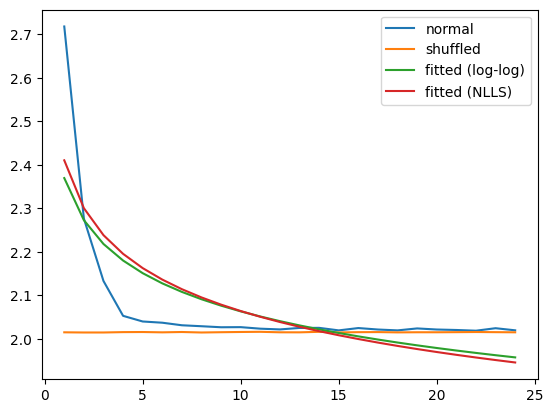

--------------------------------------------------
Progress for es language: 5/25 (elapsed time: 19.822722911834717)
Progress for es language: 10/25 (elapsed time: 19.956275939941406)
Progress for es language: 15/25 (elapsed time: 19.92461585998535)
Progress for es language: 20/25 (elapsed time: 20.004534006118774)
****** Language: es ******
Shuffled >= Normal: 0/480
right p-value: 0.0

log-log regression
fitted to y = 2.401 * x^-0.054
exponent: -0.054

non-linear least squares (NLLS) regression
fitted to y = 2.432 * x^-0.06
exponent: -0.06



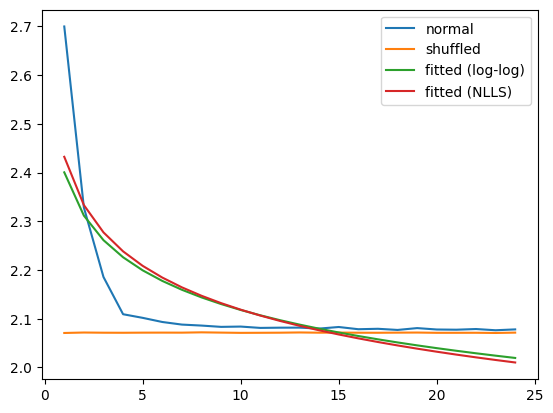

--------------------------------------------------


In [76]:
import math
import matplotlib.pyplot as plt
import time
import numpy
import csv
import scipy.stats as stats
from scipy.optimize import curve_fit

def process_data_d(data: list[str], d: int) -> dict[str, dict[str, int]]:
    # dict of token x -> token y -> f(x,y)
    processed_data: dict[str, dict[str, int]] = {}
    data_length = len(data)
    for i in range(data_length):
        token_data = processed_data.get(data[i], {})
        # should x == y be excluded?
        if i+d < data_length: # and data[i] != data[i+d]:
            # add 1 to the frequency of the token y that appears d tokens after the current token x
            token_data[data[i+d]] = token_data.get(data[i+d], 0) + 1
        elif i+d >= data_length:
            break
        processed_data[data[i]] = token_data
    return processed_data

def calculate_I_d(data: dict[str, dict[str, int]]) -> float:
    # calculate f(x|d) and f(y|d) and F
    f_x_d: dict[str, int] = {}
    f_y_d: dict[str, int] = {}
    F = 0
    for token_x in data:
        f_x_d[token_x] = 0
        for token_y in data[token_x]:
            f_y_d[token_y] = f_y_d.get(token_y, 0) + data[token_x][token_y]
            f_x_d[token_x] += data[token_x][token_y]
            F += data[token_x][token_y]

    # calculate I(d)
    I_d = 0
    for token_x in data:
        for token_y in data[token_x]:
            p_x_y = data[token_x][token_y]/F
            p_x_d = f_x_d[token_x]/F
            p_y_d = f_y_d[token_y]/F
            # sum p(x,y|d)*log(p(x,y|d)/(p(x|d)*p(y|d))) for each x and y
            I_d += p_x_y * math.log(p_x_y/(p_x_d * p_y_d))
    return I_d

def power_law(x, a, b):
        return a * numpy.power(x, b)

for language in tokenized_sources:
    I_d: dict[int, float] = {}
    I_d_shuffled: dict[int, float] = {}
    x = []
    y = []
    y_shuffled = []
    total = 0
    shuffled_geq_normal = 0
    start = time.time()
    shuffled_data = tokenized_sources[language].copy()

    d_max = 25

    for d in range(1, d_max):       
        data_d = process_data_d(tokenized_sources[language], d)
        I_d[d] = calculate_I_d(data_d)

        # shuffle the data and calculate I(d) for the shuffled data multiple times to get a p-value with bigger sample size
        sample_size = 20
        val = 0
        for i in range(sample_size):
            numpy.random.shuffle(shuffled_data)
            data_shuffled = process_data_d(shuffled_data, d)
            tmp_val = calculate_I_d(data_shuffled)
            val += tmp_val

            total += 1
            if tmp_val >= I_d[d]:
                shuffled_geq_normal += 1

        I_d_shuffled[d] = val/sample_size

        x.append(d)
        y.append(I_d[d])
        y_shuffled.append(I_d_shuffled[d])

        if d%5 == 0 and d != 0:
            end = time.time()
            print(f"Progress for {language} language: {d}/{d_max} (elapsed time: {end - start})")
            start = time.time()
    
    with open(f'../data/{language}_normal.csv', 'w+') as file:
        writer = csv.writer(file)
        
        writer.writerow(["d", "I(d)"])
        
        for d in I_d:
            writer.writerow([d, I_d[d]])

    with open(f'../data/{language}_shuffled.csv', 'w+') as file:
        writer = csv.writer(file)
        
        writer.writerow(["d", "I(d)"])
        
        for d in I_d:
            writer.writerow([d, I_d_shuffled[d]])

    print(f"****** Language: {language} ******")
    print(f"Shuffled >= Normal: {shuffled_geq_normal}/{total}")
    # the right p-value is the proportion of times the shuffled I(d) is greater than or equal to the normal I(d)
    print(f"right p-value: {shuffled_geq_normal/total}")
    print()

    # fit the data to a power law with log-log regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(numpy.log(x), numpy.log(y))
    exponent = slope
    coefficient = numpy.exp(intercept)
    print("log-log regression")
    print(f"fitted to y = {round(coefficient, 3)} * x^{round(exponent, 3)}")
    print(f"exponent: {round(exponent, 3)}")
    print()
    y_fitted = [coefficient * x_val**exponent for x_val in x]

    # fit the data to a power law with curve_fit (non-linear least squares regression)
    params, covariance = curve_fit(power_law, x, y, p0=[1, 1])
    coefficient, exponent = params
    print("non-linear least squares (NLLS) regression")
    print(f"fitted to y = {round(coefficient, 3)} * x^{round(exponent, 3)}")
    print(f"exponent: {round(exponent, 3)}")
    print()
    y_fitted2 = [coefficient * x_val**exponent for x_val in x]

    plt.plot(x, y, label="normal")
    plt.plot(x, y_shuffled, label="shuffled")
    plt.plot(x, y_fitted, label="fitted (log-log)")
    plt.plot(x, y_fitted2, label="fitted (NLLS)")
    plt.legend()
    plt.show()

    print("--------------------------------------------------")
